In this notebook, we demonstrate the generation of a linear program and explore its feasible region, which can either be empty or non-empty. Our primary goal is to accelerate the solving of linear programs using machine learning techniques, even if it means selecting nearly optimal solutions in favor of speed.

For this demonstration, we will keep our decision variables (n) and constraints (m) constant. Varying the input dimensions significantly increases the complexity of the project, and this aspect will be addressed in more detail in the further research section.

The linear program will be presented in the standard form:

**Objective:**
Minimize \( z = c^T x \)

**Subject to:**
\[ Ax <= b \]

**Variables:**
\[ x >= 0 \]

Where:
- \( x \) is the vector of decision variables,
- \( c \) is the coefficient vector for the objective function,
- \( A \) is the matrix of coefficients for the constraints,
- \( b \) is the vector of upper bounds for the constraints.

By maintaining a fixed number of decision variables and constraints, we simplify our initial model and focus on developing effective machine learning techniques to accelerate the solving process. Future work will explore the implications and strategies for handling variable input dimensions.

In [59]:
# NOTE: This section details the generation of random linear programs.
# TODO: Further work is needed to ensure balanced data through dimensionality and attribute variation.

import pulp as pl
import numpy as np

def generate_random_linear_program(minimize=True, num_decision_vars=5, num_constraints=3, iteration=0):
    """
    Generate a random linear program for demonstration purposes.

    Args:
    minimize (bool): If True, generate a minimization problem; otherwise, generate a maximization problem.
    num_decision_vars (int): Number of decision variables.
    num_constraints (int): Number of constraints.
    iteration (int): Iteration count for naming the problem instance.

    Returns:
    linear_program (LpProblem): Generated linear program.
    a_matrix (list): Coefficients of decision variables in constraints.
    b_vector (list): Right-hand side values of constraints.
    c_vector (list): Coefficients of decision variables in the objective function.
    """
    # Determine whether to generate a minimization or maximization problem
    if minimize:
        linear_program = pl.LpProblem(f"Linear_Program_{iteration}", pl.LpMinimize)
    else:
        linear_program = pl.LpProblem(f"Linear_Program_{iteration}", pl.LpMaximize)

    # Generate decision variables with lower bounds set to zero
    decision_vars = pl.LpVariable.dicts("x", range(num_decision_vars), lowBound=0)

    # Create the objective function with random coefficients
    objective_terms = [(decision_vars[i], np.random.randint(-10, 10)) for i in range(num_decision_vars)]
    objective_function = pl.LpAffineExpression(objective_terms)
    c_vector = [coef for _, coef in objective_terms]

    # Add the objective function to the linear program
    linear_program += objective_function

    # Generate constraints with random coefficients and right-hand side values
    a_matrix = []
    b_vector = []
    for _ in range(num_constraints):
        constraint_terms = [(decision_vars[i], np.random.randint(-10, 10)) for i in range(num_decision_vars)]
        constraint_function = pl.LpAffineExpression(constraint_terms)
        rhs_value = np.random.randint(-10, 10)
        constraint = pl.LpConstraint(constraint_function, pl.LpConstraintLE, rhs=rhs_value)
        linear_program += constraint

        # Collect coefficients and RHS values for output
        a_matrix.append([coef for _, coef in constraint_terms])
        b_vector.append(rhs_value)

    return linear_program, a_matrix, b_vector, c_vector

In [60]:
# Example usage
example_linear_program_output = generate_random_linear_program(minimize=True, num_decision_vars=2, num_constraints=2)
print(example_linear_program_output)

example_linear_program = example_linear_program_output[0]
example_solver = pl.PULP_CBC_CMD()
example_result = example_linear_program.solve(example_solver)
example_status = pl.LpStatus[example_linear_program.status]
print(example_status)

(Linear_Program_0:
MINIMIZE
-5*x_0 + -7*x_1 + 0
SUBJECT TO
_C1: - 8 x_0 - 5 x_1 <= 3

_C2: 3 x_0 - 3 x_1 <= 3

VARIABLES
x_0 Continuous
x_1 Continuous
, [[-8, -5], [3, -3]], [3, 3], [-5, -7])
Unbounded


In [61]:
# NOTE: This section details the creation of balanced training data for the machine learning model.
# TODO: Further work is needed to ensure balanced data by eliminating biasing attributes and increasing dimensionality.

def create_balanced_data(size=1000, bias=None):
    """
    Create trivially balanced training data for machine learning models.

    Args:
    size (int): Desired size of the training dataset.
    bias (int or None): Category biasing parameter. 
                        If None, balance both categories equally.
                        If 0, bias towards feasible solutions.
                        If 1, bias towards infeasible solutions.
                        If -1, no bias, include all statuses.

    Returns:
    training_data (list): List of formatted linear programs and their categories.
    """
    n, m = 2, 2  # Number of decision variables and constraints
    training_data = []
    last_category = None

    while len(training_data) < size:
        # Generate a random linear program
        temp_lp, a_matrix, b_vector, c_vector = generate_random_linear_program(minimize=True, num_decision_vars=n, num_constraints=m)
        solver = pl.PULP_CBC_CMD()

        # Format the linear program
        lp_formatted = [a_matrix, b_vector, c_vector]

        # Solve the linear program to create data labels
        result = temp_lp.solve(solver)
        status = pl.LpStatus[temp_lp.status]

        # Pairing data and labels while balancing into the training set
        if bias is None:
            if status == "Optimal" and (last_category is None or last_category == 1):
                lp_category = 0
                training_data.append([lp_formatted, lp_category])
                last_category = 0
            elif status == "Infeasible" and (last_category is None or last_category == 0):
                lp_category = 1
                training_data.append([lp_formatted, lp_category])
                last_category = 1

        elif bias == 0:
            if status == "Optimal":
                lp_category = 0
                training_data.append([lp_formatted, lp_category])
                last_category = 0

        elif bias == 1:
            if status == "Infeasible":
                lp_category = 1
                training_data.append([lp_formatted, lp_category])
                last_category = 1

        elif bias == -1:  # No Bias
            if status in ["Optimal", "Unbounded"]:
                lp_category = 0
                training_data.append([lp_formatted, lp_category])
                last_category = 0
            elif status == "Infeasible":
                lp_category = 1
                training_data.append([lp_formatted, lp_category])
                last_category = 1

    return training_data

In [62]:
# Example usage
example_training_data = create_balanced_data(10)
print(f"Example Data Length: {len(example_training_data)}")

category_count = [0, 0]
for item in example_training_data:
    if item[1] == 0:
        category_count[0] += 1
    else:
        category_count[1] += 1
print(f"Example Data Balance [Feasible, Infeasible]: {category_count}")
print(f"Example Entry: \n{example_training_data[0]}")

Example Data Length: 10
Example Data Balance [Feasible, Infeasible]: [5, 5]
Example Entry: 
[[[[9, -10], [-1, -8]], [0, 3], [3, 1]], 0]


In [84]:
# NOTE: This section visualizes the training data to understand its distribution and balance.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_training_data(training_data):
    """
    Plot the distribution of the training data.

    Args:
    training_data (list): The dataset to be visualized.
    """
    feasible_counts = [0, 0]
    infeasible_counts = [0, 0]

    for item in training_data:
        if item[1] == 0:  # Feasible
            feasible_counts[0] += np.sum(np.array(item[0][0]) > 0)
            feasible_counts[1] += np.sum(np.array(item[0][0]) <= 0)
        else:  # Infeasible
            infeasible_counts[0] += np.sum(np.array(item[0][0]) > 0)
            infeasible_counts[1] += np.sum(np.array(item[0][0]) <= 0)

    categories = ['Feasible', 'Infeasible']
    counts_positive = [feasible_counts[0], infeasible_counts[0]]
    counts_negative = [feasible_counts[1], infeasible_counts[1]]

    # Plotting the distribution
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(x=categories, y=counts_positive, ax=ax[0])
    ax[0].set_title('Count of Positive Coefficients')
    ax[0].set_ylabel('Count')

    sns.barplot(x=categories, y=counts_negative, ax=ax[1])
    ax[1].set_title('Count of Negative or Zero Coefficients')
    ax[1].set_ylabel('Count')

    plt.suptitle('Distribution of Training Data Coefficients')
    plt.show()

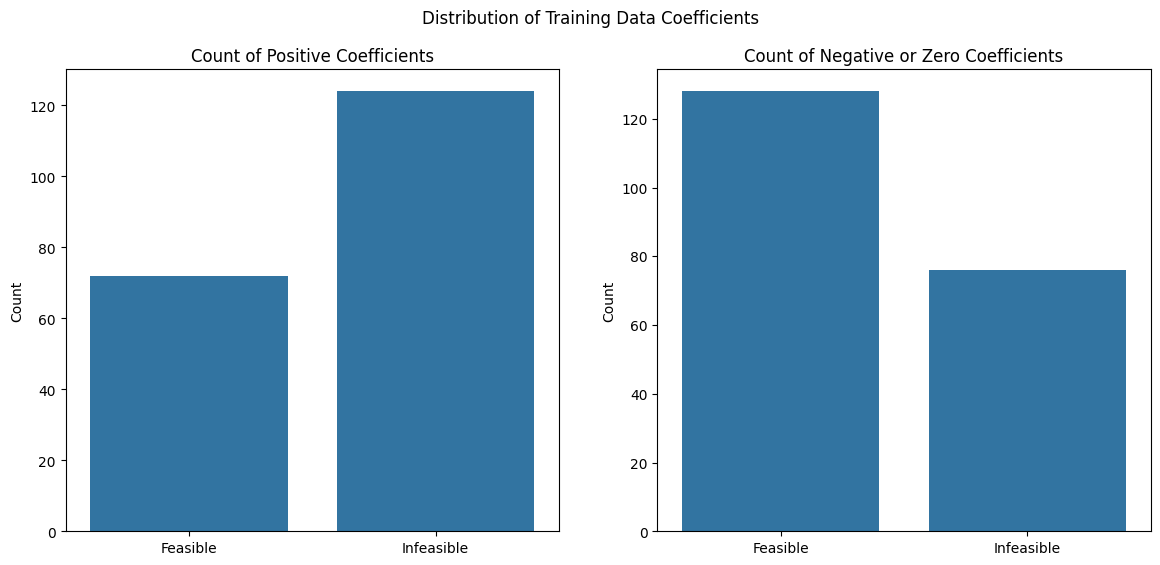

In [85]:
# Example usage for visualization
example_training_data = create_balanced_data(100)
plot_training_data(example_training_data)

In [63]:
# NOTE: This section generates the training and testing data for the machine learning model.

import random

# Generate and balance the training data
training_data = create_balanced_data(10000)
print(f"Training Data Length: {len(training_data)}")

# Calculate and print the balance of feasible and infeasible categories in the training data
training_category_count = [0, 0]
for item in training_data:
    if item[1] == 0:
        training_category_count[0] += 1
    else:
        training_category_count[1] += 1
print(f"Training Data Balance [Feasible, Infeasible]: {training_category_count}")

# Shuffle the training data
random.shuffle(training_data)

# Generate and balance the testing data
testing_data = create_balanced_data(5000)
print(f"Testing Data Length: {len(testing_data)}")

# Calculate and print the balance of feasible and infeasible categories in the testing data
testing_category_count = [0, 0]
for item in testing_data:
    if item[1] == 0:
        testing_category_count[0] += 1
    else:
        testing_category_count[1] += 1
print(f"Testing Data Balance [Feasible, Infeasible]: {testing_category_count}")

# Shuffle the testing data
random.shuffle(testing_data)

Training Data Length: 10000
Training Data Balance [Feasible, Infeasible]: [5000, 5000]
Testing Data Length: 5000
Testing Data Balance [Feasible, Infeasible]: [2500, 2500]


In [64]:
# NOTE: This section formats and saves the training and testing data.

import pickle

def format_and_save_data(data, x_filename, y_filename):
    """
    Formats the data and saves it to pickle files.

    Args:
    data (list): The dataset to be formatted and saved.
    x_filename (str): The filename for the features.
    y_filename (str): The filename for the labels.
    """
    x_data = []
    y_data = []

    for features, label in data:
        pre_format = np.stack([features[1], features[2]], axis=1)
        x_data.append(np.concatenate([features[0], pre_format], axis=1))
        y_data.append(label)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    with open(x_filename, "wb") as x_file:
        pickle.dump(x_data, x_file)

    with open(y_filename, "wb") as y_file:
        pickle.dump(y_data, y_file)

# Format and save training data
format_and_save_data(training_data, "x_train.pickle", "y_train.pickle")
print("Training data saved successfully.")

# Format and save testing data
format_and_save_data(testing_data, "x_test.pickle", "y_test.pickle")
print("Testing data saved successfully.")

Training data saved successfully.
Testing data saved successfully.


In [65]:
# NOTE: This section trains the machine learning model.

import pickle
import tensorflow as tf
from tensorflow import keras

# Load the training and testing data
with open("x_train.pickle", "rb") as file:
    x_train = pickle.load(file)

with open("y_train.pickle", "rb") as file:
    y_train = pickle.load(file)

with open("x_test.pickle", "rb") as file:
    x_test = pickle.load(file)

with open("y_test.pickle", "rb") as file:
    y_test = pickle.load(file)

# Normalize the training and testing data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Define the custom activation function
def custom_softmax_v2(x):
    return tf.nn.softmax(x)

# Register the custom activation function
tf.keras.utils.get_custom_objects().update({'custom_softmax_v2': tf.keras.layers.Activation(custom_softmax_v2)})

# Build the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=custom_softmax_v2)  # Use custom activation function
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_split=0.2)

# Evaluate the model on the testing data
val_loss, val_acc = model.evaluate(x_test, y_test)
print(f"Model Error: {val_loss}")
print(f"Model Accuracy: {val_acc}")

# Save the model using the .keras extension
model.save('lp_feasibility.keras')
print("Model saved successfully as 'lp_feasibility.keras'")

Epoch 1/10


c:\Repository\convex-optimization-estimation\myenv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8397 - loss: 0.3362 - val_accuracy: 0.9540 - val_loss: 0.1059
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9536 - loss: 0.1137 - val_accuracy: 0.9555 - val_loss: 0.0981
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9604 - loss: 0.0873 - val_accuracy: 0.9710 - val_loss: 0.0699
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9699 - loss: 0.0681 - val_accuracy: 0.9730 - val_loss: 0.0706
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9736 - loss: 0.0656 - val_accuracy: 0.9770 - val_loss: 0.0612
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9776 - loss: 0.0564 - val_accuracy: 0.9725 - val_loss: 0.0715
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9811 - loss: 0.0527 - val_accuracy: 0.9775 - val_loss: 0.0545
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9787 - loss: 0.0536 - val_accuracy: 0.9545 - val_

In [66]:
# NOTE: This section performs cross-validation.

import tensorflow as tf
import numpy as np

# Define the custom activation function again when loading the model
def custom_softmax_v2(x):
    return tf.nn.softmax(x)

# Register the custom activation function
tf.keras.utils.get_custom_objects().update({'custom_softmax_v2': tf.keras.layers.Activation(custom_softmax_v2)})

# Load the trained model with the custom activation function
model = tf.keras.models.load_model('lp_feasibility.keras')

def evaluate_model(validation_data):
    """
    Evaluate the model on the given validation data.
    
    Args:
    validation_data (list): The validation data to evaluate the model on.
    
    Returns:
    tuple: The validation loss and accuracy.
    """
    category_count = [0, 0]
    x_validate = []
    y_validate = []

    for features, label in validation_data:
        if label == 0:
            category_count[0] += 1
        else:
            category_count[1] += 1

        pre_format = np.stack([features[1], features[2]], axis=1)
        x_validate.append(np.concatenate([features[0], pre_format], axis=1))
        y_validate.append(label)
    
    x_validate = np.array(x_validate)
    y_validate = np.array(y_validate)
    
    val_loss, val_acc = model.evaluate(x_validate, y_validate, verbose=0)
    return val_loss, val_acc, category_count

# Test 1: Normal Balance
test1_validation_data = create_balanced_data(500)
val_loss, val_acc, category_count = evaluate_model(test1_validation_data)
print(f"Test 1 Data Balance [Feasible, Infeasible]: {category_count}")
print(f"Model 1 Error: {val_loss}")
print(f"Model 1 Accuracy: {val_acc}")

# Test 2: Feasible Bias
test2_validation_data = create_balanced_data(500, bias=0)
val_loss, val_acc, category_count = evaluate_model(test2_validation_data)
print(f"Test 2 Data Balance [Feasible, Infeasible]: {category_count}")
print(f"Model 2 Error: {val_loss}")
print(f"Model 2 Accuracy: {val_acc}")

# Test 3: Infeasible Bias
test3_validation_data = create_balanced_data(500, bias=1)
val_loss, val_acc, category_count = evaluate_model(test3_validation_data)
print(f"Test 3 Data Balance [Feasible, Infeasible]: {category_count}")
print(f"Model 3 Error: {val_loss}")
print(f"Model 3 Accuracy: {val_acc}")

# Test 4: No Bias
test4_validation_data = create_balanced_data(1000, bias=-1)
val_loss, val_acc, category_count = evaluate_model(test4_validation_data)
print(f"Test 4 Data Balance [Feasible, Infeasible]: {category_count}")
print(f"Model 4 Error: {val_loss}")
print(f"Model 4 Accuracy: {val_acc}")

Test 1 Data Balance [Feasible, Infeasible]: [250, 250]
Model 1 Error: 2.1524736881256104
Model 1 Accuracy: 0.8999999761581421
Test 2 Data Balance [Feasible, Infeasible]: [500, 0]
Model 2 Error: 2.4216151237487793
Model 2 Accuracy: 0.9139999747276306
Test 3 Data Balance [Feasible, Infeasible]: [0, 500]
Model 3 Error: 0.7386316061019897
Model 3 Accuracy: 0.9300000071525574
Test 4 Data Balance [Feasible, Infeasible]: [719, 281]
Model 4 Error: 3.108795642852783
Model 4 Accuracy: 0.8880000114440918


In [67]:
# NOTE: This section uses the trained model to predict the feasibility of a sample linear program.

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pulp as pl
import os

# Suppress TensorFlow warnings (optional)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any desired level: '0', '1', '2', '3'

# Generating a Sample Linear Program
sample_lp, a_matrix, b_vector, c_vector = generate_random_linear_program(minimize=True, num_decision_vars=2, num_constraints=2)
sample_lp_formatted = [a_matrix, b_vector, c_vector]
solver = pl.PULP_CBC_CMD()

# Solving Linear Program for Data Label Creation
result = sample_lp.solve(solver)
status = pl.LpStatus[sample_lp.status]

# Pre-processing for Model
sample_data = [[[a_matrix, b_vector, c_vector], "EMPTY_LABEL"]]
x_sample = []

for features, _ in sample_data:
    pre_format = np.stack([features[1], features[2]], axis=1)
    x_sample.append(np.concatenate([features[0], pre_format], axis=1))

x_sample = np.array(x_sample)
x_sample = tf.keras.utils.normalize(x_sample, axis=1)

# Loading the Model and Predicting Feasibility
testing_model = tf.keras.models.load_model('lp_feasibility.keras')
predictions = testing_model.predict(x_sample)

# Determining Feasibility from the Solver Status
if status in ["Optimal", "Unbounded"]:
    answer = "Feasible"
else:
    answer = "Infeasible"

# Displaying the Results
print(sample_lp)
print(f"Chance of Feasibility:   {predictions[0][0]}")
print(f"Chance of Infeasibility: {predictions[0][1]}")
print(f"Linear Program: {answer}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Linear_Program_0:
MINIMIZE
5*x_0 + 5*x_1 + 0
SUBJECT TO
_C1: 9 x_0 - 4 x_1 <= -10

_C2: - x_0 - 2 x_1 <= -3

VARIABLES
x_0 Continuous
x_1 Continuous

Chance of Feasibility:   0.9997861981391907
Chance of Infeasibility: 0.00021381698024924845
Linear Program: Feasible


A 
[[-9  2]
 [ 2  6]
 [ 4  7]]

b 
[10  1  3]

c 
[  6 -10]

Test_Generation:
MINIMIZE
6*x1 + -10*x2 + 0
SUBJECT TO
_C1: - 9 x1 + 2 x2 <= 10

_C2: 2 x1 + 6 x2 <= 1

_C3: 4 x1 + 7 x2 <= 3

VARIABLES
x1 free Continuous
x2 free Continuous

Optimal


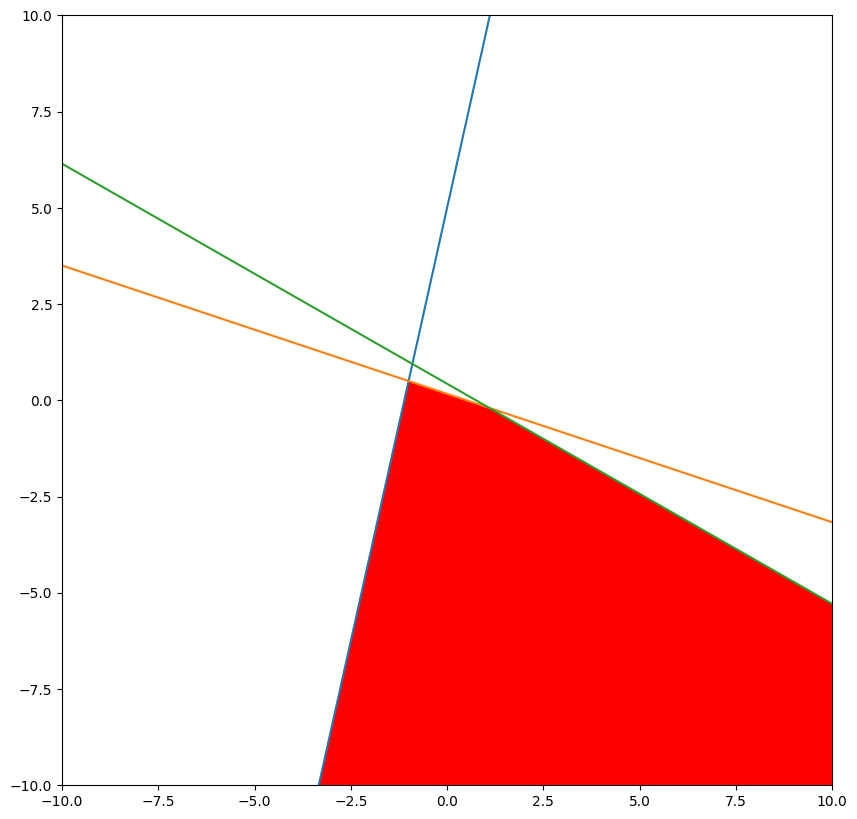

In [68]:
# NOTE: This section includes graphing and visualizing linear programs.

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog
import pulp

def feasible_point(A, b):
    # Finds the center of the largest sphere fitting in the convex hull
    norm_vector = np.linalg.norm(A, axis=1)
    A_ = np.hstack((A, norm_vector[:, None]))
    b_ = b[:, None]
    c = np.zeros((A.shape[1] + 1,))
    c[-1] = -1
    res = linprog(c, A_ub=A_, b_ub=b[:, None], bounds=(None, None))
    return res.x[:-1]
    
def hs_intersection(A, b):
    interior_point = feasible_point(A, b)
    halfspaces = np.hstack((A, -b[:, None]))
    hs = HalfspaceIntersection(halfspaces, interior_point)
    return hs

def plt_halfspace(a, b, bbox, ax):
    if a[1] == 0:
        ax.axvline(b / a[0])
    else:
        x = np.linspace(bbox[0][0], bbox[0][1], 100)
        ax.plot(x, (b - a[0] * x) / a[1])

def add_bbox(A, b, xrange, yrange):
    A = np.vstack((A, [
        [-1,  0],
        [ 1,  0],
        [ 0, -1],
        [ 0,  1],
    ]))
    b = np.hstack((b, [-xrange[0], xrange[1], -yrange[0], yrange[1]]))
    return A, b

def solve_convex_set(A, b, bbox, ax=None):
    A_, b_ = add_bbox(A, b, *bbox)
    interior_point = feasible_point(A_, b_)
    hs = hs_intersection(A_, b_)
    points = hs.intersections
    hull = ConvexHull(points)
    return points[hull.vertices], interior_point, hs

def plot_convex_set(A, b, bbox, ax=None):
    points, interior_point, hs = solve_convex_set(A, b, bbox, ax=ax)
    if ax is None:
        _, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])
    ax.fill(points[:, 0], points[:, 1], 'r')
    return points, interior_point, hs

def plot_inequalities(A, b, c, bbox, ax=None):
    points, interior_point, hs = plot_convex_set(A, b, bbox, ax=ax)
    for a_k, b_k in zip(A, b):
        plt_halfspace(a_k, b_k, bbox, ax)
    return points, interior_point, hs

def generate_linear_program(n, m, lower_entry_bound, upper_entry_bound):
    a_matrix = np.random.randint(lower_entry_bound, upper_entry_bound, size=(m, n))
    b_vector = np.random.randint(lower_entry_bound, upper_entry_bound, size=(m))
    c_vector = np.random.randint(lower_entry_bound, upper_entry_bound, size=(n))

    # Making Ax <= b with b being positive
    for i in range(len(b_vector)):
        if b_vector[i] <= 0:
            b_vector[i] = b_vector[i] * -1
            a_matrix[i] = a_matrix[i] * -1
    
    return (a_matrix, b_vector, c_vector)

n = 2
m = 3

lower_entry_bound = -10
upper_entry_bound = 10

a_matrix, b_vector, c_vector = generate_linear_program(n, m, lower_entry_bound, upper_entry_bound)

print(f'A \n{a_matrix}\n')
print(f'b \n{b_vector}\n')
print(f'c \n{c_vector}\n')

# Setting up the linear program
linear_program = pulp.LpProblem("Test Generation", pulp.LpMinimize)
solver = pulp.PULP_CBC_CMD()

# Defining decision variables
x1 = pulp.LpVariable('x1', cat='Continuous')
x2 = pulp.LpVariable('x2', cat='Continuous')

# Adding objective function
linear_program += c_vector[0] * x1 + c_vector[1] * x2, 'Z'

# Adding constraints
for i in range(len(a_matrix)):
    linear_program += a_matrix[i][0] * x1 + a_matrix[i][1] * x2 <= b_vector[i]

print(linear_program)

# Solving the linear program
result = linear_program.solve(solver)
status = pulp.LpStatus[linear_program.status]
print(status)

# Visualizing the linear program
plt.rcParams['figure.figsize'] = (10, 10)
bbox = [(-10, 10), (-10, 10)]
fig, ax = plt.subplots()
plot_inequalities(a_matrix, b_vector, c_vector, bbox, ax)
plt.show()